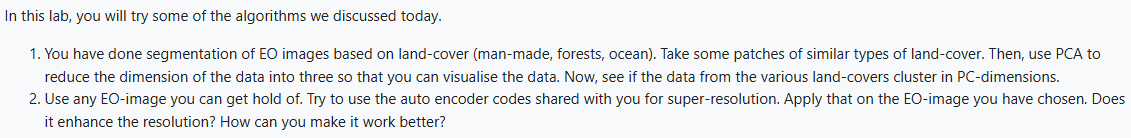

Well i was doing the previous lab with 3 bands so it was already possible to show them. But, lets try PCA on 4 bands into 2/3

In [8]:
import glob
import rasterio
import numpy as np
from rasterio.windows import from_bounds
from pyproj import Transformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

In [9]:
# Paths to the 10m bands for both urban and forest areas
folder_u = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2C_MSIL2A_20251119T094321_N0511_R036_T34UDA_20251119T113511.SAFE\\GRANULE\\L2A_T34UDA_A006298_20251119T094316\\IMG_DATA\\R10m"
folder_a = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2A_MSIL2A_20251027T141101_N0511_R110_T21MWV_20251027T171317.SAFE\\GRANULE\\L2A_T21MWV_A054047_20251027T141102\\IMG_DATA\\R10m"
# Paths to all the bands
band_paths_u = {b: glob.glob(f"{folder_u}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02","B08","TCI","WVP","AOT"]}
band_paths_a = {b: glob.glob(f"{folder_a}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02","B08","TCI","WVP","AOT"]}

lets start with the amazon, which worked great at the end of the previous lab, and kraków central area

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8512].


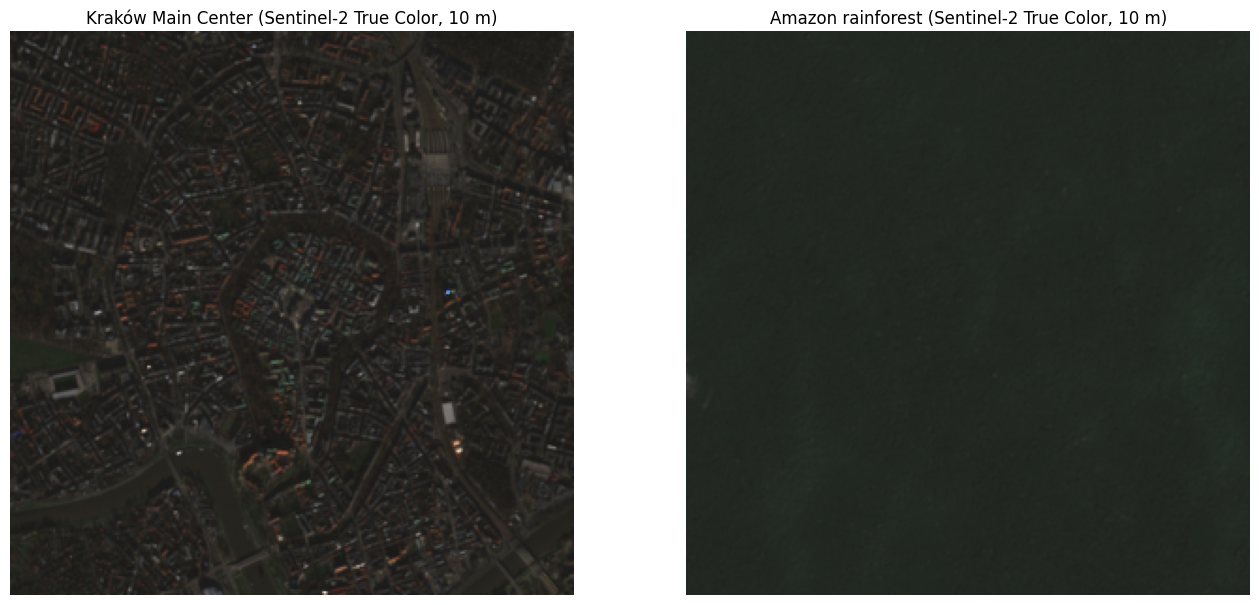

In [10]:
def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

with rasterio.open(band_paths_a["B04"]) as src_a:
    crs_a = src_a.crs
with rasterio.open(band_paths_u["B04"]) as src_u:
    crs_u = src_u.crs

lon_a, lat_a = -56.714447, -0.312698     # Amazon Rainforest tile center coordinates
lon_u, lat_u = 19.9372205, 50.0614312   # Rynek Główny coordinates

transformer_a = Transformer.from_crs("EPSG:4326", crs_a, always_xy=True)
transformer_u = Transformer.from_crs("EPSG:4326", crs_u, always_xy=True)

x_a, y_a = transformer_a.transform(lon_a, lat_a)
x_u, y_u = transformer_u.transform(lon_u, lat_u)
dx = 1500
dy = 1500

xmin_a, ymin_a, xmax_a, ymax_a = x_a - dx, y_a - dy, x_a + dx, y_a + dy
xmin_u, ymin_u, xmax_u, ymax_u = x_u - dx, y_u - dy, x_u + dx, y_u + dy
scale = 1.0 / 10000.0

b4_a = read_crop(band_paths_a["B04"], (xmin_a, ymin_a, xmax_a, ymax_a)).astype(np.float32) * scale
b3_a = read_crop(band_paths_a["B03"], (xmin_a, ymin_a, xmax_a, ymax_a)).astype(np.float32) * scale
b2_a = read_crop(band_paths_a["B02"], (xmin_a, ymin_a, xmax_a, ymax_a)).astype(np.float32) * scale
b8_a = read_crop(band_paths_a["B08"], (xmin_a, ymin_a, xmax_a, ymax_a)).astype(np.float32) * scale

b4_u = read_crop(band_paths_u["B04"], (xmin_u, ymin_u, xmax_u, ymax_u)).astype(np.float32) * scale
b3_u = read_crop(band_paths_u["B03"], (xmin_u, ymin_u, xmax_u, ymax_u)).astype(np.float32) * scale
b2_u = read_crop(band_paths_u["B02"], (xmin_u, ymin_u, xmax_u, ymax_u)).astype(np.float32) * scale
b8_u = read_crop(band_paths_u["B08"], (xmin_u, ymin_u, xmax_u, ymax_u)).astype(np.float32) * scale

patch_a = np.dstack((b4_a, b3_a, b2_a, b8_a))
patch_u = np.dstack((b4_u, b3_u, b2_u, b8_u))
# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[1].imshow(patch_a[:, :, :3])
axs[1].set_title("Amazon rainforest (Sentinel-2 True Color, 10 m)")
axs[1].axis("off")
axs[0].imshow(patch_u[:, :, :3])
axs[0].set_title("Kraków Main Center (Sentinel-2 True Color, 10 m)")
axs[0].axis("off")
plt.show()

Text(0, 0.5, 'Principal Component 2')

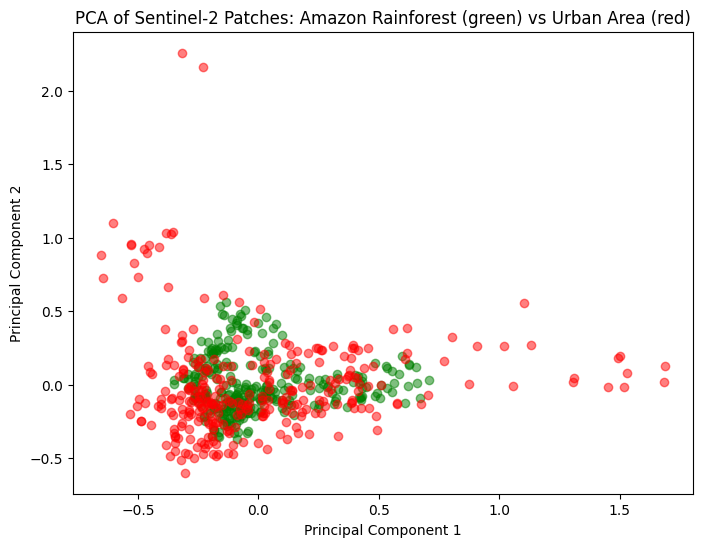

In [11]:

patch_flat_a = patch_a.reshape(patch_a.shape[0], -1)
patch_flat_u = patch_u.reshape(patch_u.shape[0], -1)
scikit_pca = PCA(n_components=2)
X_spca_a = scikit_pca.fit_transform(patch_flat_a)
X_spca_u = scikit_pca.fit_transform(patch_flat_u)

plt.figure(figsize=(8,6))
plt.scatter(X_spca_a[:, 0], X_spca_a[:, 1], color='green', alpha=0.5)
plt.scatter(X_spca_u[:, 0], X_spca_u[:, 1], color='red', alpha=0.5)
plt.title('PCA of Sentinel-2 Patches: Amazon Rainforest (green) vs Urban Area (red)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

Well thats not too good, but it is expected. Lets try the kernel trick

Text(0, 0.5, 'Principal Component 2')

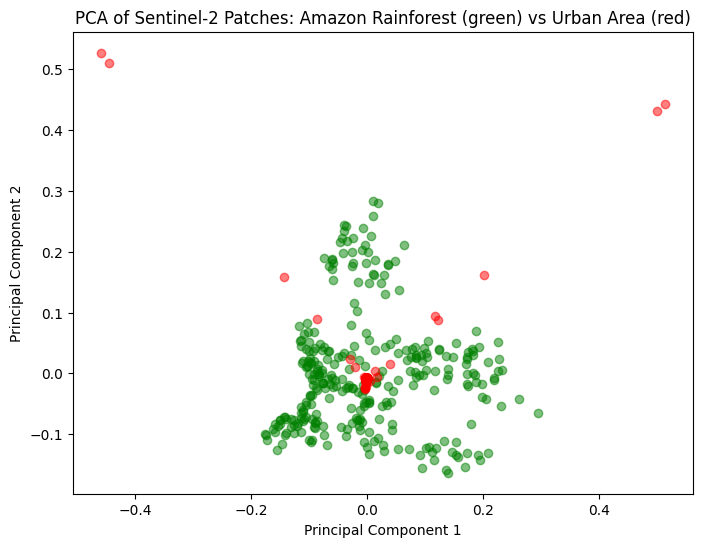

In [12]:
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=6)
X_skernpca_a = scikit_kpca.fit_transform(patch_flat_a)
X_skernpca_u = scikit_kpca.fit_transform(patch_flat_u)

plt.figure(figsize=(8,6))
plt.scatter(X_skernpca_a[:, 0], X_skernpca_a[:, 1], color='green', alpha=0.5)
plt.scatter(X_skernpca_u[:, 0], X_skernpca_u[:, 1], color='red', alpha=0.5)
plt.title('PCA of Sentinel-2 Patches: Amazon Rainforest (green) vs Urban Area (red)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

Interesting, that concentration of urban points might be something to go off of when trying to classify after this reduction of dimensions. Different gamma values provide wildly different results, i tested a bunch but i will not say 100% that 6 is best.

Lets try kernel pca into 3 components, it might just turn out better than simply r g b

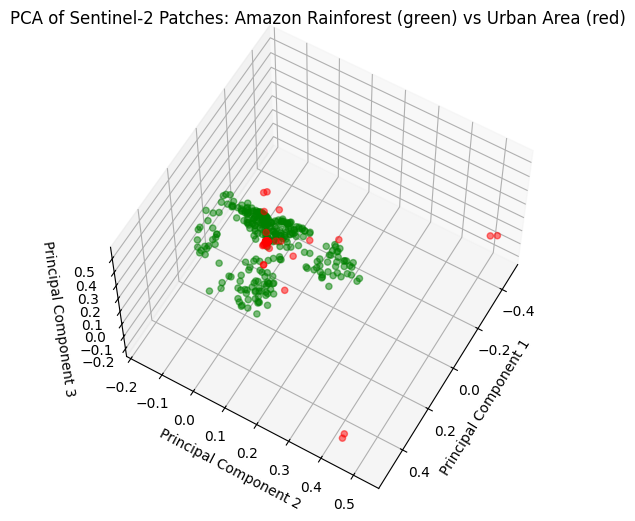

In [13]:
scikit_kpca = KernelPCA(n_components=3, kernel='rbf', gamma=6)
X_skernpca_a = scikit_kpca.fit_transform(patch_flat_a)
X_skernpca_u = scikit_kpca.fit_transform(patch_flat_u)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_skernpca_a[:, 0], X_skernpca_a[:, 1], X_skernpca_a[:, 2], color='green', alpha=0.5)
ax.scatter(X_skernpca_u[:, 0], X_skernpca_u[:, 1], X_skernpca_u[:, 2], color='red', alpha=0.5)
ax.set_title('PCA of Sentinel-2 Patches: Amazon Rainforest (green) vs Urban Area (red)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

ax.view_init(elev=60, azim=30)  # Change elevation and azimuth angle

Well, it doesn't look as promising as I thought it would but lets try to run a classifier based on this anyway. Let's use the functions from class 4

In [14]:
def make_model(first_layer_units, second_layer_units, activation_func):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten()
    ])
    
    model.add(layers.Dense(first_layer_units, activation=activation_func))
    
    if second_layer_units != 0:
        model.add(layers.Dense(second_layer_units, activation=activation_func))

    model.add(layers.Dense(1, activation="sigmoid"))
    
    return model


def compile_and_train(model, X_train, y_train, epochs=20, verbose=1):
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_split=0.2,# adding validation dataset (20% of test dataset)
        batch_size=32,
        verbose=verbose
    )
    
    return history


def plot_training_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    # Plot accuracy and loss side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # Accuracy plot
    axs[0].plot(epochs, acc, "o-", label="Training accuracy")
    axs[0].plot(epochs, val_acc, "o-", label="Validation accuracy")
    axs[0].set_title("Training and Validation Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Loss plot
    axs[1].plot(epochs, loss, "o-", label="Training loss")
    axs[1].plot(epochs, val_loss, "o-", label="Validation loss")
    axs[1].set_title("Training and Validation Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show() 

Dataset shape: (600, 3)
Labels count: [300 300]



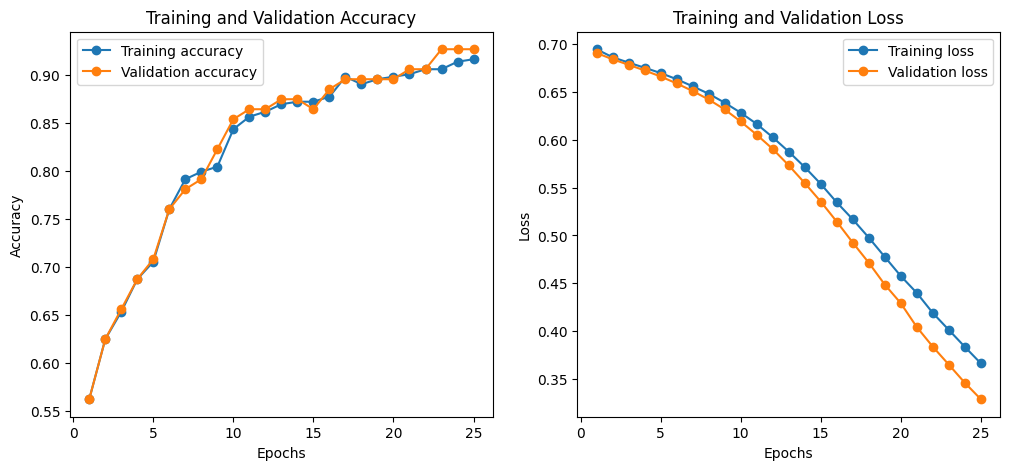

In [15]:
X = np.vstack((X_skernpca_a, X_skernpca_u))
y = np.hstack((np.zeros(X_skernpca_a.shape[0]), np.ones(X_skernpca_u.shape[0])))

y = np.array(y).astype("float32")


print("Dataset shape:", X.shape)
print("Labels count:", np.bincount(y.astype(int)))
input_shape=(3,)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

tf.keras.backend.clear_session()

model = make_model(32, 32, "relu")
history = compile_and_train(model, X_train, y_train, epochs=25, verbose=0)
plot_training_history(history)

### AUTOENCODERS

Using this tutorial: https://colab.research.google.com/github/ilopezfr/image-superres/blob/master/Image_Super_Resolution_using_Autoencoders.ipynb#scrollTo=1QGkU3q21Y2E

In [16]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from keras.models import Model
from keras import regularizers

# Encoder

n = 256
chan = 3
input_img = Input(shape=(n, n, chan))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l3 = Dropout(0.5)(l3)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)

# Decoder

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l3 = Dropout(0.3)(l3)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(chan, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder = Model(input_img, decoded)
# You'll understand later what this is
autoencoder_hfenn = Model(input_img, decoded)

In [17]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [18]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import rasterio

def openeo_tif_to_imread_array(
    tif_path,
    bands=(1, 2, 3),
    normalize=True,
    dtype=np.float32
):

    with rasterio.open(tif_path) as src:
        data = src.read(bands)  # (C, H, W)

    # Move channels last: (H, W, C)
    img = np.moveaxis(data, 0, -1)

    if normalize:
        img = img.astype(np.float32)
        min_val = img.min()
        max_val = img.max()
        if max_val > min_val:
            img = (img - min_val) / (max_val - min_val)

    return img.astype(dtype)


def train_batches(just_load_dataset=False):
    batches = 10 # Number of images to have at the same time in a batch
    batch = 0 # counter images in the current batch (grows over time and then resets for each batch)
    batch_nb = 0 # counter of current batch index
    max_batches = -1 # If you want to train only on a limited number of images to finish the training even faster.
    
    ep = 120 # Number of epochs
    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] # Resulting high res dataset
    x_train_down2 = [] # Resulting low res dataset
    
    for root, dirnames, filenames in os.walk("C:\\Users\\kacpe\\Desktop\\Studia\\ML\\cities\\"): # generate the files names
        for filename in filenames:
            if re.search("\.(tif)$", filename):
                if batch_nb == max_batches: # If we limit the number of batches, just return earlier
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = openeo_tif_to_imread_array(filepath)
                if len(image.shape) > 2:
                    # Resize the image so that every image is the same size
                    image_resized = resize(image, (256, 256))
                    print('Loaded image:', image_resized.shape, filepath)
                    # Add this image to the high res dataset
                    x_train_n.append(image_resized) 
                    print('Added high res image:', image_resized.shape)
                    # Rescale it 0.5x and 2x so that it is a low res image but still has 256x256 resolution
                    x_train_down.append(
                                    rescale(
                                        rescale(
                                            image_resized,
                                            0.5,
                                            channel_axis=-1,
                                            preserve_range=True,
                                            anti_aliasing=True
                                        ),
                                        2.0,
                                        channel_axis=-1,
                                        preserve_range=True,
                                        anti_aliasing=True
                                    )
                                )

                    print('Added low res image:', x_train_down[-1].shape)
                    batch += 1
                    print(batch, '/', batches)
                    if batch == batches:
                        batch_nb += 1
                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')
                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0
    return x_train_n2, x_train_down2

<>:48: SyntaxWarning: invalid escape sequence '\.'
<>:48: SyntaxWarning: invalid escape sequence '\.'
C:\Users\kacpe\AppData\Local\Temp\ipykernel_19736\3639903460.py:48: SyntaxWarning: invalid escape sequence '\.'
  if re.search("\.(tif)$", filename):
C:\Users\kacpe\AppData\Local\Temp\ipykernel_19736\3639903460.py:3: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import ndimage, misc


In [20]:
x_train_n = []
x_train_down = []
autoencoder.build((None, 256, 256, 3))
autoencoder.compile(
    optimizer="adam",
    loss="mse"
)
x_train_n, x_train_down = train_batches()

Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\cairo_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res image: (256, 256, 3)
1 / 10
Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\delhi_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res image: (256, 256, 3)
2 / 10
Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\london_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res image: (256, 256, 3)
3 / 10
Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\los_angeles_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res image: (256, 256, 3)
4 / 10
Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\mexico_city_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res image: (256, 256, 3)
5 / 10
Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\new_york_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)


In [21]:
# We clip the output so that it doesn't produce weird colors
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17123406..1.1664356].


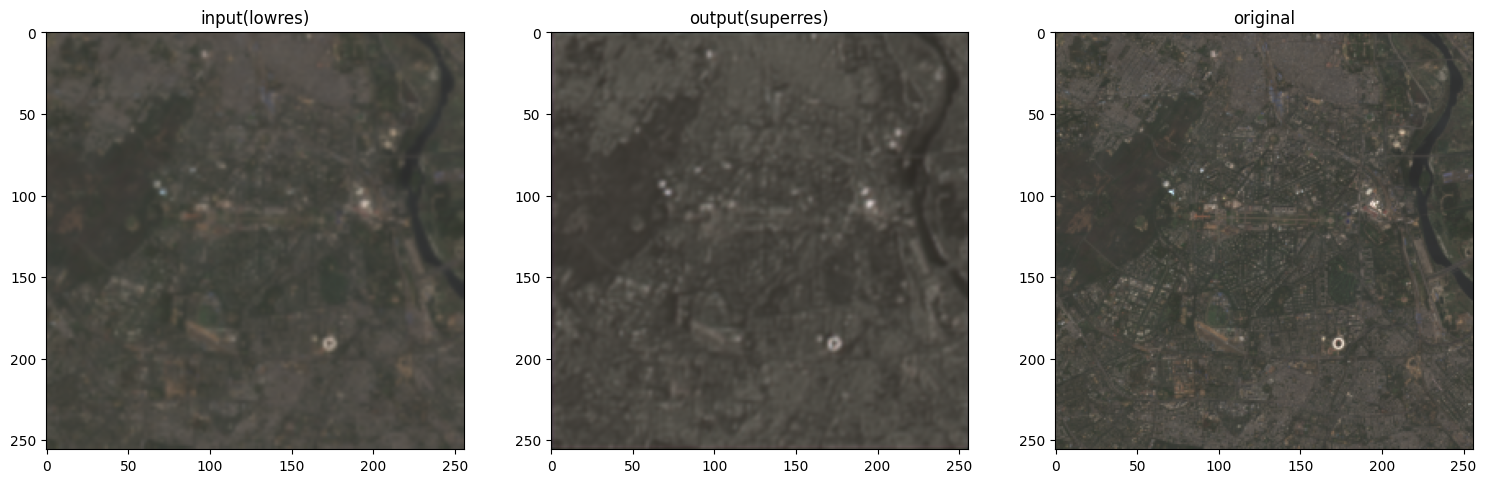

In [22]:
image_index = 1
import matplotlib.pyplot as plt

plt.figure(figsize=(64, 64))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index] * 3)  #Input (low-res)
ax.set_title("input(lowres)")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index] * 3)  # Output (supre-res recovered image)
ax.set_title("output(superres)")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index] * 3)  # Ground truth (high-res) 
ax.set_title("original")
plt.show()

It looks decent but without mathematical way to compare them it is not possible to say for sure if it is better or worse.

In [28]:
def openeo_tif_to_imread_array_segmented(
    tif_path,
    bands=(1, 2, 3),
    normalize=True,
    dtype=np.float32,
    num_segments=9  # 9 for 3x3 grid, 16 for 4x4 grid
):

    with rasterio.open(tif_path) as src:
        data = src.read(bands)  # (C, H, W)

    # Move channels last: (H, W, C)
    img = np.moveaxis(data, 0, -1)

    if normalize:
        img = img.astype(np.float32)
        min_val = img.min()
        max_val = img.max()
        if max_val > min_val:
            img = (img - min_val) / (max_val - min_val)

    img = img.astype(dtype)
    
    # Determine grid size
    if num_segments == 9:
        grid_size = 3
    elif num_segments == 16:
        grid_size = 4
    else:
        raise ValueError(f"num_segments must be 9 or 16, got {num_segments}")
    
    # Get dimensions
    h, w, c = img.shape
    
    # Calculate segment dimensions
    seg_h = h // grid_size
    seg_w = w // grid_size
    
    # Create list to store segments
    segments = []
    
    # Split into grid
    for i in range(grid_size):
        for j in range(grid_size):
            y_start = i * seg_h
            y_end = (i + 1) * seg_h
            x_start = j * seg_w
            x_end = (j + 1) * seg_w
            
            segment = img[y_start:y_end, x_start:x_end, :]
            segments.append(segment)
    
    return segments


def train_batches(just_load_dataset=False):
    batches = 16 # Number of images to have at the same time in a batch
    batch = 0 # counter images in the current batch (grows over time and then resets for each batch)
    batch_nb = 0 # counter of current batch index
    max_batches = 3 # If you want to train only on a limited number of images to finish the training even faster.
    
    ep = 16 # Number of epochs
    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] # Resulting high res dataset
    x_train_down2 = [] # Resulting low res dataset
    
    for root, dirnames, filenames in os.walk("C:\\Users\\kacpe\\Desktop\\Studia\\ML\\cities\\"): # generate the files names
        for filename in filenames:
            if re.search("\.(tif)$", filename):
                if batch_nb == max_batches: # If we limit the number of batches, just return earlier
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                segments = openeo_tif_to_imread_array_segmented(filepath, num_segments=16)
                for image in segments:
                    if len(image.shape) > 2:
                        # Resize the image so that every image is the same size
                        image_resized = resize(image, (256, 256))
                        print('Loaded image:', image_resized.shape, filepath)
                        # Add this image to the high res dataset
                        x_train_n.append(image_resized) 
                        print('Added high res image:', image_resized.shape)
                        # Rescale it 0.5x and 2x so that it is a low res image but still has 256x256 resolution
                        x_train_down.append(
                                        rescale(
                                            rescale(
                                                image_resized,
                                                0.5,
                                                channel_axis=-1,
                                                preserve_range=True,
                                                anti_aliasing=True
                                            ),
                                            2.0,
                                            channel_axis=-1,
                                            preserve_range=True,
                                            anti_aliasing=True
                                        )
                                    )

                        print('Added low res image:', x_train_down[-1].shape)
                        batch += 1
                        print(batch, '/', batches)
                        if batch == batches:
                            batch_nb += 1
                            x_train_n2 = np.array(x_train_n)
                            x_train_down2 = np.array(x_train_down)
                            
                            if just_load_dataset:
                                return x_train_n2, x_train_down2
                            
                            print('Training batch', batch_nb, '(', batches, ')')
                            autoencoder.fit(x_train_down2, x_train_n2,
                                epochs=ep,
                                batch_size=160,
                                shuffle=True,
                                validation_split=0.15)
                        
                            x_train_n = []
                            x_train_down = []
                        
                            batch = 0
    return x_train_n2, x_train_down2

<>:72: SyntaxWarning: invalid escape sequence '\.'
<>:72: SyntaxWarning: invalid escape sequence '\.'
C:\Users\kacpe\AppData\Local\Temp\ipykernel_19736\2843442488.py:72: SyntaxWarning: invalid escape sequence '\.'
  if re.search("\.(tif)$", filename):


In [29]:
x_train_n = []
x_train_down = []
autoencoder.build((None, 256, 256, 3))
autoencoder.compile(
    optimizer="adam",
    loss="mse"
)
x_train_n, x_train_down = train_batches()

Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\cairo_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res image: (256, 256, 3)
1 / 16
Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\cairo_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res image: (256, 256, 3)
2 / 16
Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\cairo_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res image: (256, 256, 3)
3 / 16
Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\cairo_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res image: (256, 256, 3)
4 / 16
Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\cairo_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res image: (256, 256, 3)
5 / 16
Loaded image: (256, 256, 3) C:\Users\kacpe\Desktop\Studia\ML\cities\cairo_Sentinel_2_RGB.tif
Added high res image: (256, 256, 3)
Added low res im

In [30]:
# We clip the output so that it doesn't produce weird colors
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [31]:
# Save the trained model
autoencoder.save('autoencoder_low.keras')
# Or save just the weights:
# autoencoder.save_weights('autoencoder_weights.weights.h5')

# To load later:
# from keras.models import load_model
# autoencoder = load_model('autoencoder_superres.keras')

In [32]:
import numpy as np
from scipy.ndimage import filters

def l_o_g(img, sigma):
    '''
    Laplacian of Gaussian filter (channel-wise)
    -> img: input image
    -> sigma: gaussian_laplace sigma
    <- filtered image
    '''
    while len(img.shape) < 3:
        img = img[..., np.newaxis]
    out = img.copy()
    for chan in range(img.shape[2]):
        out[..., chan] = filters.gaussian_laplace(img[..., chan], sigma)
    return out

def hfenn(orig, res):
    '''
    High Frequency Error Norm (Normalized) metric for comparison of original and result images
    The metric independent to image size (in contrast to regular HFEN)
    Inputs are expected to be float in range [0, 1] (with possible overflow)
    -> ori: original image
    -> res: result image
    <- HFENN value
    '''
    sgima = 1.5  # From DLMRI paper
    return np.mean((l_o_g(orig - res, sgima)) ** 2) * 1e4  # magnification

### Model used on the Zoomed in London center.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18084943..1.0156186].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16341378..1.2434553].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17649654..2.1095617].


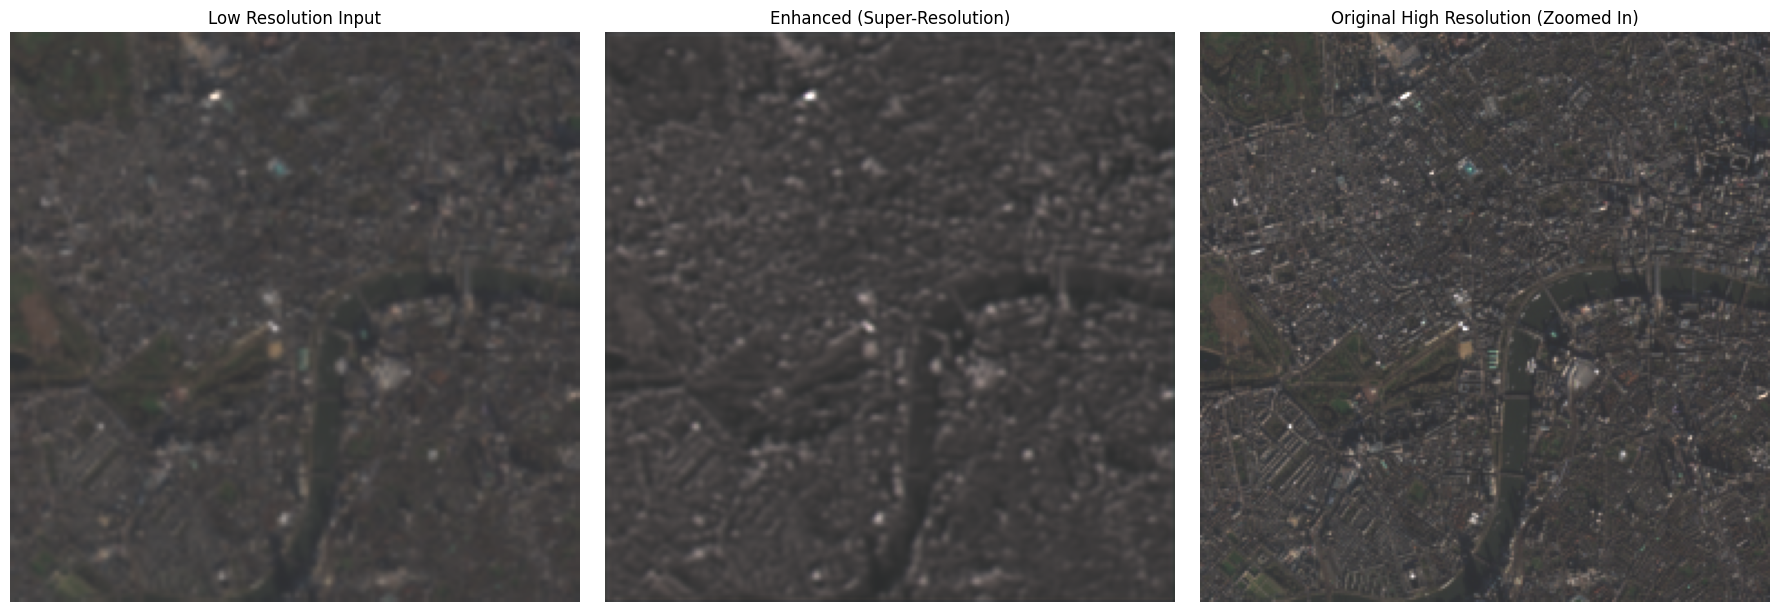

0.0068251602


C:\Users\kacpe\AppData\Local\Temp\ipykernel_19736\1062172665.py:15: DeprecationWarning: Please import `gaussian_laplace` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  out[..., chan] = filters.gaussian_laplace(img[..., chan], sigma)


In [34]:
# Load a single image and enhance it - ZOOMED IN VERSION
test_image_path = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\cities\\london_Sentinel_2_RGB.tif"

# Read and normalize the image
original_full = openeo_tif_to_imread_array(test_image_path)

# Crop a central region to zoom in (512x512 pixels from center)
h, w = original_full.shape[:2]
crop_size = 512
y_start = (h - crop_size) // 2
x_start = (w - crop_size) // 2
original_cropped = original_full[y_start:y_start+crop_size, x_start:x_start+crop_size, :]

# Resize to 256x256 for the model
original_resized = resize(original_cropped, (256, 256))

# Create low-res version (simulating what the model expects as input)
low_res = rescale(
    rescale(original_resized, 0.5, channel_axis=-1, preserve_range=True, anti_aliasing=True),
    2.0, channel_axis=-1, preserve_range=True, anti_aliasing=True
)

# Add batch dimension for prediction
low_res_batch = np.expand_dims(low_res, axis=0)

from keras.models import load_model
autoencoder = load_model('autoencoder_low.keras')
# Use the model to enhance
enhanced = autoencoder.predict(low_res_batch)[0]
enhanced = np.clip(enhanced, 0.0, 1.0)

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(low_res * 3)
axes[0].set_title("Low Resolution Input")
axes[0].axis('off')
axes[1].imshow(enhanced * 3)
axes[1].set_title("Enhanced (Super-Resolution)")
axes[1].axis('off')
axes[2].imshow(original_resized * 3)
axes[2].set_title("Original High Resolution (Zoomed In)")
axes[2].axis('off')
plt.tight_layout()
plt.show()

print(hfenn(original_resized, low_res) - hfenn(original_resized, enhanced))

I mean it works!!?? Well 0.0068 improvement is not amazing but it shurely works (from mathrmaticall standpoint at least). So it means that it works and it surely can be improved by tweaking the training settings.